<a href="https://colab.research.google.com/github/Tony363/Chartmetric_Analysis/blob/master/Chartmetric_DataConsolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [607]:
   """
    forcasting followers and listeners over 6 month regression
    model around followers and listeners
    cut off followers lower than 10000
    cut off listeners 100000
    popularity cut off 40
    
    *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables
    homepage and dashboard(UI)
    step 1 <- visual representation of what the platform looks like (basic sustainable platform)
      - barebones UI
      - with plot metrics
    -heursticals timeseries giving it a weights average and aggregate
      (proof of concept first)<-small easy project easy money
    - diff var / value mean
    - pair xy regressor    
    * continue with logistic regression
    * straighten out timeseries
    """

'\n forcasting followers and listeners over 6 month regression\n model around followers and listeners\n cut off followers lower than 10000\n cut off listeners 100000\n popularity cut off 40\n \n *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables\n homepage and dashboard(UI)\n step 1 <- visual representation of what the platform looks like (basic sustainable platform)\n   - barebones UI\n   - with plot metrics\n -heursticals timeseries giving it a weights average and aggregate\n   (proof of concept first)<-small easy project easy money\n - diff var / value mean\n - pair xy regressor    \n * continue with logistic regression\n * straighten out timeseries\n '

model around followers and listeners


In [608]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 13:24:30 2020

@author: tony
"""

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.set_index("Chartmetric_ID",inplace=True)
    return df

# set some display options so easier to view all columns at once
def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    
def rename_columns(df):
    subidx = [df.columns.get_loc(col) for col in df.columns if "Subject" in col] 
    subjects = df.columns[[subidx]]
    df.rename(columns={df.columns[subidx[idx]]:df.iloc[0,subidx[idx]] for idx,sub in enumerate(subidx)},inplace=True)
    for subject,idx in enumerate(range(0,len(df.columns),7)):
        df.rename(columns={sub:df.columns[subidx[subject]]+" "+sub for idx,sub in enumerate(df.columns[idx+1:idx+7])},inplace=True)
    return df

def get_df_info(df):
    # print memory usage
    print(df.memory_usage(),'\n')
    # take an initial look at our data
    print(df.head(),'\n')

    # take a look at the columns in our data set
    print("The columns are:")
    print(df.columns,'\n')

    # look at data types for each
    info = df.info()
    print(info,'\n')

    # take a look at data types, and it looks like we have a pretty clean data set!
    # However, I think the 0 popularity scores might throw the model(s) off a bit.
    print("Do we have any nulls?")
    print(f"Looks like we have {df.isnull().sum().sum()} nulls\n")
    
    subject_col = []
    statsdf = []
    # look at basic metric mapping
    for idx,col in enumerate(df.columns):
        if idx % 7 != 0:
            try:
                stats = df.agg({col:['min','max','median','mean','skew']})
                subject_col.append(col)
                statsdf.append(stats.transpose())
            except Exception as e:
                # print(e)
                continue
    statsdf = pd.concat(statsdf,axis=0,ignore_index=True)
    statsdf.set_index([pd.Index(subject_col)],inplace=True)
    return statsdf
    # print(df.agg({col:['min','max','median','skew'] for idx,col in enumerate(df.columns) if idx % 7 != 0}))

# calculate and print more stats from the df
def get_stats(df):
    df.reset_index(inplace=True)
    # print stats for various metrics
    print()
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['Chartmetric_ID'].unique().shape} unique artists")
    print(f"There are {df['popularity value.1'].unique().shape} unique popularity scores")
    print(f"The mean popularity score is {df['popularity value.1'].mean()}")
    print(f"There are {df[df['popularity value.1'] > 55]['popularity value.1'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity value.1'] > 75]['popularity value.1'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity value.1'] > 80]['popularity value.1'].count() / df.shape[0])*100:.2f} % of artists have a popularity score > 80")
    
def group_time(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    time = df.iloc[:,timeidx]
    time = time.reset_index().drop('Chartmetric_ID',axis=1).loc[:,'followers timestp']
    df = df.drop(df.columns[timeidx[1:]],axis=1).reset_index().groupby(['followers timestp'])[['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3']].first()
    df.fillna(df.mean(),inplace=True)
    df['fx followers'] = df['followers value'].pct_change()
    df['fx popularity'] = df['popularity value.1'].pct_change()
    df['fx listeners'] = df['listeners value.2'].pct_change()
    df['fx ratio'] = df['followers_to_listeners_ratio value.3'].pct_change()
    df_std = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3'],axis=1)),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    df_std['time series'] = time
    df_std.set_index('time series',inplace=True)
    df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df.drop(['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3'],axis=1)),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    df_norm['time series'] = time
    df_norm.set_index('time series',inplace=True)
    df_std_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_std),columns=['fx followers','fx popularity','fx listeners','fx ratio'])
    return df.drop(['fx followers','fx popularity','fx listeners','fx ratio'],axis=1),df.drop(['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3'],axis=1),df_std,df_norm,df_std_norm

def artist_diff_metric(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    valueidx = [df.columns.get_loc(col) for col in df.columns if "value" in col] 
    df.drop(df.columns[timeidx+valueidx],axis=1,inplace=True)
    df.reset_index(inplace=True)
    artist_unique_row = [df.groupby('Chartmetric_ID').groups[artist][0] for artist in df.groupby('Chartmetric_ID').groups]
    df = df.loc[artist_unique_row,:].drop(['followers','popularity','listeners'],axis=1).set_index('Chartmetric_ID')
    return df

def Multivariable_Matrix(df,original,col):
    cmatrix = []
    for shift,time in zip(range(df.shape[0]),df.index):
        cseries = df.loc[:,col].shift(-shift)
        smatrix = pd.DataFrame({f'shift {shift}':cseries.values})
        cmatrix.append(smatrix)
    cmatrix = pd.concat(cmatrix,axis=1)
    cmatrix.drop(cmatrix.index[90:], inplace=True)
    cmatrix.index = original.index[:cmatrix.shape[0]]
    return cmatrix
    
def calc_correlations(df, cutoff=0.5):
    corr = df.corr()
    corr_data = corr[corr > cutoff]
    corr_list = df.corr().unstack().sort_values(kind="quicksort",ascending=False)
    return corr_list.drop(corr_list.index[:20]),corr_data

# nice way to truncate the column names to display easier
# can be used with various metrics
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    describe = df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()
    pd.set_option("display.max_colwidth", O) 
    return describe

# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    print(au_corr[0:n])
    return au_corr[0:n]
    
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(f"{col_x}")
    plt.ylabel(f"{col_y}")
    plt.show()

def plot_scatter_matrix(df, num_rows):
    scatter_matrix(df[:num_rows], alpha=0.2, figsize=(6, 6), diagonal='kde')
    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
  
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=16)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.2f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('True',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)
    
# plot polularity scores distribution
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Distribution of Popularity Scores - Entire Data Set")

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot undersampling methodology
def undersample_plot(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")
    
    # create line to shade to the right of
    line = ax.get_lines()[-1]
    x_line, y_line = line.get_data()
    mask = x_line > 0.55
    x_line, y_line = x_line[mask], y_line[mask]
    ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

    # get values for and plot first label
    label_x = 0.5
    label_y = 4
    arrow_x = 0.6
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "First, sample all songs in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=arrow_properties)

    # Get values for and plot second label
    label_x = 0.1
    label_y = 3
    arrow_x = 0.2
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "Next, randomly sample \n n songs in this range", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
        arrowprops=arrow_properties)

    # plot final word box
    plt.annotate(
        "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n songs", xy=(0.6, 2),
        xytext=(0.62, 2),
        bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for followers feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['followers value'].mean()))
    print('Mean value for followers feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['followers value'].mean()))
    print('Mean value for listeners feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'].mean()))
    print('Mean value for listeners feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'].mean()))
  
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['followers value'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['followers value'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'])
    plt.show()

def validation_plot(y_test, pred_test):
    """
    Parameters
    ----------
    y_test : validation set.
    pred_test : prediction on test.

    Returns
    -------
    None.

    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, pred_test, color="b")
    # ax.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=4)
    ax.set_xlabel("preds")
    ax.set_ylabel("y_test")
    ax.set_title("validate on pred")
    plt.show()


# choose cutoff, sample popular data, randomly sample unpopular data, and combine the dfs
def split_sample_combine(df, cutoff=2.682048, col='fx popularity', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] >= cutoff].copy()

    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] < cutoff].copy()

    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]

    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df[col] / 100
    ssc_df['pop_cat'] = np.where(ssc_df[col] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df[col] > cutoff, 1, 0)
    return ssc_df

# initial linear regression function, and plots
def linear_regression_initial(df,Y):
    df = df.copy()
    X_cols = df.columns.drop(Y)

    y_col = [Y]

    X = df[X_cols]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    X_train = sm.add_constant(X_train)
    # Instantiate OLS model, fit, predict, get errors
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    fitted_vals_train = results.predict(X_train)
    stu_resid = results.resid_pearson
    residuals = results.resid
    y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals_train, \
                            'stu_resid': stu_resid})

    # Print the results
    print(results.summary())

    # QQ Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.title(f"QQ Plot-{Y} Initial Linear Regression")
    fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
    plt.show()

    # validate pred
    validation_plot(y_train, fitted_vals_train)

    # Residuals Plot
    y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
    plt.title(f"{Y} regression")
    plt.show()
    return y_vals

def lin_reg_forcast(df,Y,PARAMETERS = {
        'max_depth':20,
        'min_child_weight': 5,
        'eta':.1,
        'subsample': .7,
        'colsample_bytree': .7,
        'nthread':-1,
        'objective':'reg:squarederror',
        'eval_metric':'rmse'
    }):
    df = df.copy()
    X_cols = df.columns.drop(Y)

    y_col = [Y]

    X = df[X_cols]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    dtrain = xgb.DMatrix(X_train, y_train,nthread=-1)
    dtest = xgb.DMatrix(X_test, y_test,nthread=-1)

    bst = xgb.train(
        params=PARAMETERS,
        dtrain=dtrain,
        # num_boost_round=999,
        # evals=[(dtest,"Test")],
        # early_stopping_rounds=10,
        )
    pred_test = bst.predict(dtrain)
    pred_leaf = bst.predict(dtrain,pred_leaf=True)
    print(pred_leaf)
    return pred_test

# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=0.029425,col='popularity value.1', rand=0, sig_only=False):
    df = df.copy()
    X, y = return_X_y_logistic(split_sample_combine(df, cutoff,col, rand=rand))
    X = standardize_X(X)
    X_const = add_constant(X, prepend=True)
    print("X_const\n",X_const)
    print("Y\n",y)
    
    logit_model = Logit(y, X_const).fit(solver='lbfgs',skip_hessian=True,max_iter=20000)
    
    print(logit_model.summary())

    return logit_model

def logistic_regression_with_kfold(df, cutoff=2.682048, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")

# various data standardization and X/y split functions for logisitic reression
# based on the columns you want to standardize and return
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['fx followers','fx popularity','fx listeners','fx ratio','pop_frac']

    # use 1's and 0's for logistic
    y_col = 'pop_bin'

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def standardize_X(X):  
    X = X.copy()
    
    # standardize only columns not between 0 and 1
    for col in ['fx followers','fx listeners','fx ratio','fx popularity','pop_frac']:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['fx followers_std','fx popularity_std','fx listeners_std','fx ratio_std','pop_frac_std']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X




In [609]:
# data clean
df = load_data()  
set_view_options(max_cols=50, max_rows=50, max_colwidth=40, dis_width=250)
duplicated = True in df.columns.duplicated()
print(f"duplicate columns: {duplicated}\n")
df = rename_columns(df)
df.fillna(df.mean(),inplace=True)
grp,cr,cr_std,cr_norm,cr_stdnorm = group_time(df)


duplicate columns: False



/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [610]:
# unique artist difference df
artist_diff = artist_diff_metric(df)

In [611]:
# prelim insights
get_df_info(artist_diff)

Index                                                  2056
followers weekly_diff                                  2056
followers weekly_diff_percent                          2056
followers monthly_diff                                 2056
followers monthly_diff_percent                         2056
popularity weekly_diff.1                               2056
popularity weekly_diff_percent.1                       2056
popularity monthly_diff.1                              2056
popularity monthly_diff_percent.1                      2056
listeners weekly_diff.2                                2056
listeners weekly_diff_percent.2                        2056
listeners monthly_diff.2                               2056
listeners monthly_diff_percent.2                       2056
followers_to_listeners_ratio                           2056
followers_to_listeners_ratio weekly_diff.3             2056
followers_to_listeners_ratio weekly_diff_percent.3     2056
followers_to_listeners_ratio monthly_dif

,min,max,median,mean,skew
followers weekly_diff_percent,-4.220000e-02,2.525300e+00,0.281000,0.334150,2.772352
followers monthly_diff,-9.000000e+00,1.498370e+05,334.000000,5571.241439,5.581075
followers monthly_diff_percent,-5.555600e+00,1.578950e+01,1.220800,1.484926,3.629641
popularity weekly_diff.1,-2.000000e+00,1.000000e+00,0.000000,0.113288,0.999046
popularity weekly_diff_percent.1,-8.333300e+00,8.333300e+00,0.000000,0.245786,0.835398
popularity monthly_diff.1,-3.000000e+00,1.200000e+01,0.000000,0.321194,5.566768
listeners weekly_diff.2,-1.117492e+06,1.203116e+06,-258.000000,-10383.395188,0.772958
listeners weekly_diff_percent.2,-2.500000e+01,3.846150e+01,-0.575322,0.038316,2.997182
listeners monthly_diff.2,-2.026390e+06,2.611250e+06,-21.000000,8143.071047,3.021873
listeners monthly_diff_percent.2,-6.836100e+01,2.756009e+03,-1.513400,10.773286,15.718845


In [612]:
get_df_info(cr_std)

Index            1224
fx followers     1224
fx popularity    1224
fx listeners     1224
fx ratio         1224
dtype: int64 

                          fx followers  fx popularity  fx listeners  fx ratio
time series                                                                  
2020-01-02T00:00:00.000Z           NaN            NaN           NaN       NaN
2020-01-04T00:00:00.000Z      1.281164       2.331276      2.098025 -0.513887
2020-01-08T00:00:00.000Z     -0.369903      -0.508622     -0.379410  3.263469
2020-01-10T00:00:00.000Z      1.283420       2.377945      2.162986 -0.514081
2020-01-14T00:00:00.000Z     -0.369903      -0.508733     -0.379410  3.171591 

The columns are:
Index(['fx followers', 'fx popularity', 'fx listeners', 'fx ratio'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 2020-01-02T00:00:00.000Z to 2020-01-19T00:00:00.000Z
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  

,min,max,median,mean,skew
fx popularity,-0.511329,4.104682,-0.375502,1.234393e-16,2.279031
fx listeners,-0.379410,3.802911,-0.379088,-8.107550e-17,2.441516
fx ratio,-0.515257,3.382224,-0.350564,0.000000e+00,2.561216


In [613]:
get_df_info(cr_norm)

Index            1224
fx followers     1224
fx popularity    1224
fx listeners     1224
fx ratio         1224
dtype: int64 

                          fx followers  fx popularity  fx listeners  fx ratio
time series                                                                  
2020-01-02T00:00:00.000Z           NaN            NaN           NaN       NaN
2020-01-04T00:00:00.000Z      0.410420       0.615814  5.923591e-01  0.000351
2020-01-08T00:00:00.000Z      0.000002       0.000586  3.908557e-09  0.969530
2020-01-10T00:00:00.000Z      0.410981       0.625924  6.078912e-01  0.000302
2020-01-14T00:00:00.000Z      0.000002       0.000562  4.123417e-09  0.945957 

The columns are:
Index(['fx followers', 'fx popularity', 'fx listeners', 'fx ratio'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 2020-01-02T00:00:00.000Z to 2020-01-19T00:00:00.000Z
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  

,min,max,median,mean,skew
fx popularity,0.0,1.0,0.029425,0.110773,2.279031
fx listeners,0.0,1.0,0.000077,0.090718,2.441516
fx ratio,0.0,1.0,0.042256,0.132202,2.561216


In [614]:
get_df_info(cr_stdnorm)

Index             128
fx followers     1224
fx popularity    1224
fx listeners     1224
fx ratio         1224
dtype: int64 

   fx followers  fx popularity  fx listeners  fx ratio
0           NaN            NaN           NaN       NaN
1      0.410420       0.615814  5.923591e-01  0.000351
2      0.000002       0.000586  3.908557e-09  0.969530
3      0.410981       0.625924  6.078912e-01  0.000302
4      0.000002       0.000562  4.123417e-09  0.945957 

The columns are:
Index(['fx followers', 'fx popularity', 'fx listeners', 'fx ratio'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fx followers   152 non-null    float64
 1   fx popularity  152 non-null    float64
 2   fx listeners   152 non-null    float64
 3   fx ratio       152 non-null    float64
dtypes: float64(4)
memory usage: 4.9 KB
None 

Do we have any nulls?
Lo

,min,max,median,mean,skew
fx popularity,0.0,1.0,0.029425,0.110773,2.279031
fx listeners,0.0,1.0,0.000077,0.090718,2.441516
fx ratio,0.0,1.0,0.042256,0.132202,2.561216


In [615]:
get_df_info(grp)

Index                                   1224
Chartmetric_ID                          1224
followers value                         1224
popularity value.1                      1224
listeners value.2                       1224
followers_to_listeners_ratio value.3    1224
dtype: int64 

                         Chartmetric_ID  followers value  popularity value.1  listeners value.2  followers_to_listeners_ratio value.3
followers timestp                                                                                                                    
2020-01-01T00:00:00.000Z       Lyrycyst            509.0                 3.0              190.0                                267.89
2020-01-02T00:00:00.000Z     Sam & Dave         180028.0                61.0          1462956.0                                 12.31
2020-01-03T00:00:00.000Z       Lyrycyst            509.0                 3.0              187.0                                272.19
2020-01-04T00:00:00.000Z     Sam & Dave      

,min,max,median,mean,skew
followers value,334.00,295738.00,191204.00,1.632436e+05,-0.900501
popularity value.1,2.00,67.00,59.00,4.983007e+01,-1.562816
listeners value.2,162.00,2127363.00,1577972.00,1.325069e+06,-1.254605
followers_to_listeners_ratio value.3,7.65,273.66,12.04,4.616562e+01,2.072831


In [616]:
get_df_info(artist_diff)

Index                                                  12296
followers weekly_diff                                   2056
followers weekly_diff_percent                           2056
followers monthly_diff                                  2056
followers monthly_diff_percent                          2056
popularity weekly_diff.1                                2056
popularity weekly_diff_percent.1                        2056
popularity monthly_diff.1                               2056
popularity monthly_diff_percent.1                       2056
listeners weekly_diff.2                                 2056
listeners weekly_diff_percent.2                         2056
listeners monthly_diff.2                                2056
listeners monthly_diff_percent.2                        2056
followers_to_listeners_ratio                            2056
followers_to_listeners_ratio weekly_diff.3              2056
followers_to_listeners_ratio weekly_diff_percent.3      2056
followers_to_listeners_r

,min,max,median,mean,skew
followers weekly_diff_percent,-4.220000e-02,2.525300e+00,0.281000,0.334150,2.772352
followers monthly_diff,-9.000000e+00,1.498370e+05,334.000000,5571.241439,5.581075
followers monthly_diff_percent,-5.555600e+00,1.578950e+01,1.220800,1.484926,3.629641
popularity weekly_diff.1,-2.000000e+00,1.000000e+00,0.000000,0.113288,0.999046
popularity weekly_diff_percent.1,-8.333300e+00,8.333300e+00,0.000000,0.245786,0.835398
popularity monthly_diff.1,-3.000000e+00,1.200000e+01,0.000000,0.321194,5.566768
listeners weekly_diff.2,-1.117492e+06,1.203116e+06,-258.000000,-10383.395188,0.772958
listeners weekly_diff_percent.2,-2.500000e+01,3.846150e+01,-0.575322,0.038316,2.997182
listeners monthly_diff.2,-2.026390e+06,2.611250e+06,-21.000000,8143.071047,3.021873
listeners monthly_diff_percent.2,-6.836100e+01,2.756009e+03,-1.513400,10.773286,15.718845


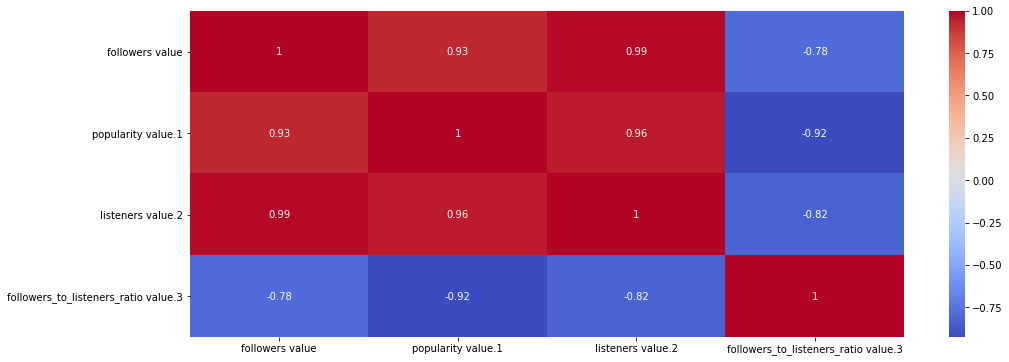

In [617]:
plot_heatmap(grp)

In [618]:
corr_list,corr_data = calc_correlations(grp)
plot_index = corr_list[corr_list > 0.5].index
for plot in plot_index:
  scatter_plot(artist_diff,plot[0],plot[1])

In [619]:
describe_cols(grp,10)

,follower...,populari...,listener...,follower...
count,153.000000,153.000000,1.530000e+02,153.000000
mean,163243.607843,49.830065,1.325069e+06,46.165621
std,89502.847784,21.880294,6.953453e+05,78.786436
min,334.000000,2.000000,1.620000e+02,7.650000
25%,182059.000000,58.000000,1.533155e+06,11.770000
50%,191204.000000,59.000000,1.577972e+06,12.040000
75%,194541.000000,61.000000,1.652460e+06,13.790000
max,295738.000000,67.000000,2.127363e+06,273.660000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


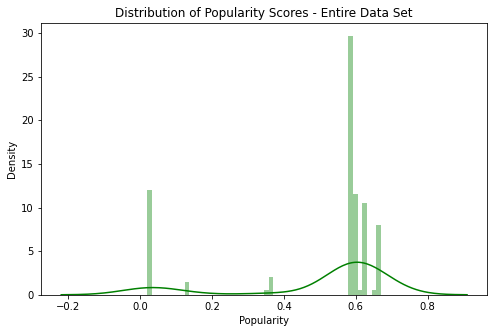

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


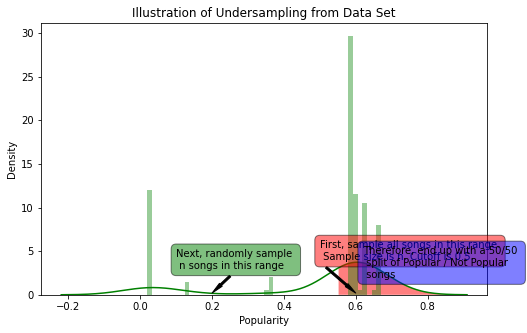

Mean value for followers feature for Popular artists: nan
Mean value for followers feature for Unpopular artists: 163243.60784313726
Mean value for listeners feature for Popular artists: nan
Mean value for listeners feature for Unpopular artists: 1325068.888888889


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

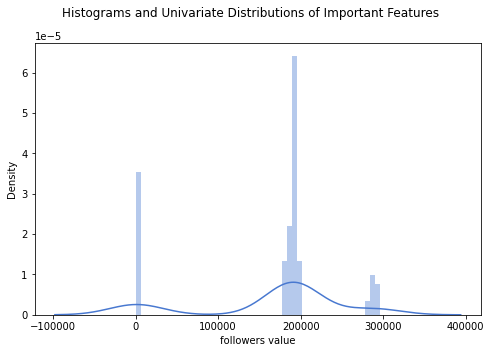

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

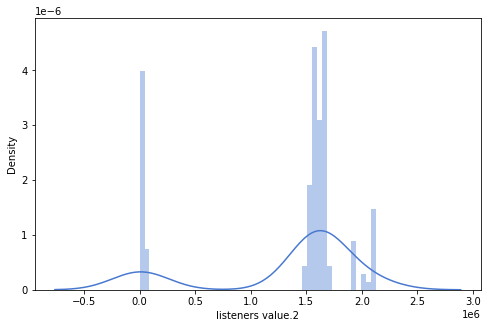

In [620]:
plot_pop_dist(grp)
undersample_plot(grp)
plot_univ_dists(grp, 70)

The top absolute correlations are:
followers value     listeners value.2                       0.986171
popularity value.1  listeners value.2                       0.961009
followers value     popularity value.1                      0.933103
popularity value.1  followers_to_listeners_ratio value.3    0.924755
listeners value.2   followers_to_listeners_ratio value.3    0.824031
followers value     followers_to_listeners_ratio value.3    0.784836
dtype: float64


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


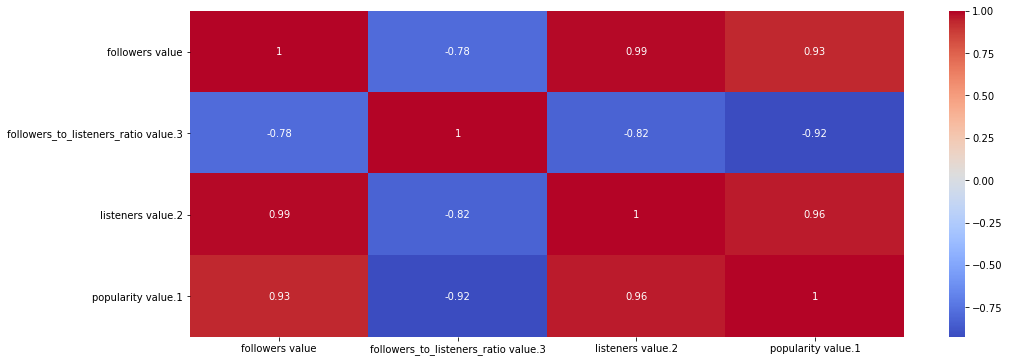

In [621]:
# Data prep
au_corr = get_top_abs_correlations(grp, 25)
train_cols = np.unique((np.asarray([(index[0],index[1]) for index in au_corr.index])).flatten())
dtrain = grp[train_cols]
dtrain.fillna(dtrain.mean(),inplace=True)
plot_heatmap(dtrain)
    

                            OLS Regression Results                            
Dep. Variable:     popularity value.1   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1875.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           2.46e-99
Time:                        06:03:13   Log-Likelihood:                -316.93
No. Observations:                 122   AIC:                             641.9
Df Residuals:                     118   BIC:                             653.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


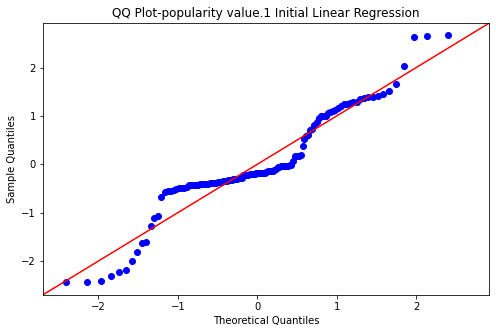

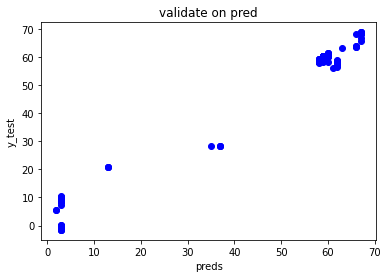

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


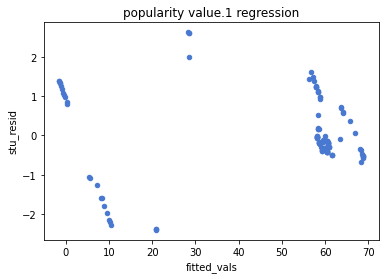

In [622]:
# regression
fitted_pop = linear_regression_initial(dtrain,Y='popularity value.1')
artist_scores = stats.zscore(fitted_pop['fitted_vals'])

In [623]:
artist_scores

array([ 0.50136391,  0.41747311,  0.52134592, -1.85418124, -0.90741896,
        0.89127823,  0.43205492,  0.46632559,  0.54254302,  0.44361903,
        0.52117155,  0.41481029,  0.52935109,  0.64909016,  0.88875968,
        0.33494624,  0.409549  ,  0.47029819,  0.44650904,  0.52117155,
        0.51840587,  0.52794277,  0.42885524, -2.16457778, -2.21415333,
        0.42733024,  0.42762516,  0.50369348, -1.80652818,  0.38504555,
        0.5726924 ,  0.45575722, -1.75016686,  0.42220815,  0.46723635,
        0.40812237, -2.22530826,  0.86662005, -2.23670357, -1.7040472 ,
        0.75678663, -1.92294837,  0.80375335,  0.4455141 ,  0.51524276,
        0.47999365,  0.50755148,  0.66133886,  0.4074258 , -0.90623223,
        0.41623555,  0.52117155,  0.52662813,  0.50760411,  0.86804943,
        0.43907031,  0.47114988,  0.66497665,  0.51610888, -0.90735376,
        0.44408351,  0.89186624,  0.88053732, -2.19164841, -2.24189854,
        0.51840587,  0.44138799,  0.4366254 ,  0.89523742,  0.51

In [624]:
get_df_info(fitted_pop)

Index          976
residuals      976
fitted_vals    976
stu_resid      976
dtype: int64 

                          residuals  fitted_vals  stu_resid
followers timestp                                          
2020-05-13T00:00:00.000Z  -1.013767    60.013767  -0.306714
2020-03-22T00:00:00.000Z  -0.131113    58.131113  -0.039668
2020-04-27T00:00:00.000Z  -0.462198    60.462198  -0.139838
2020-01-06T00:00:00.000Z  -4.151266     7.151266  -1.255962
2020-02-04T00:00:00.000Z   8.601754    28.398246   2.602454 

The columns are:
Index(['residuals', 'fitted_vals', 'stu_resid'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 2020-05-13T00:00:00.000Z to 2020-03-23T00:00:00.000Z
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   residuals    122 non-null    float64
 1   fitted_vals  122 non-null    float64
 2   stu_resid    122 non-null    float64
dtypes: float64(3)
memory usage: 3.8+ KB
None 

Do

,min,max,median,mean,skew
fitted_vals,-1.549780,68.852969,58.771565,4.876230e+01,-1.399380
stu_resid,-2.403035,2.622543,-0.185468,9.464196e-17,0.053342


In [625]:
MM = Multivariable_Matrix(pd.DataFrame(stats.zscore(fitted_pop),columns=fitted_pop.columns),fitted_pop,'fitted_vals')
MM

,shift 0,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,...,shift 97,shift 98,shift 99,shift 100,shift 101,shift 102,shift 103,shift 104,shift 105,shift 106,shift 107,shift 108,shift 109,shift 110,shift 111,shift 112,shift 113,shift 114,shift 115,shift 116,shift 117,shift 118,shift 119,shift 120,shift 121
followers timestp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-13T00:00:00.000Z,0.501364,0.417473,0.521346,-1.854181,-0.907419,0.891278,0.432055,0.466326,0.542543,0.443619,0.521172,0.414810,0.529351,0.649090,0.888760,0.334946,0.409549,0.470298,0.446509,0.521172,0.518406,0.527943,0.428855,-2.164578,-2.214153,...,-1.929103,0.416236,0.684386,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,0.432012,-2.241899,0.370996,0.442490,0.542543,-1.776183,0.887593,-2.158327,0.503693,-2.18362,0.42101
2020-03-22T00:00:00.000Z,0.417473,0.521346,-1.854181,-0.907419,0.891278,0.432055,0.466326,0.542543,0.443619,0.521172,0.414810,0.529351,0.649090,0.888760,0.334946,0.409549,0.470298,0.446509,0.521172,0.518406,0.527943,0.428855,-2.164578,-2.214153,0.427330,...,0.416236,0.684386,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,0.432012,-2.241899,0.370996,0.442490,0.542543,-1.776183,0.887593,-2.158327,0.503693,-2.183620,0.42101,NaN
2020-04-27T00:00:00.000Z,0.521346,-1.854181,-0.907419,0.891278,0.432055,0.466326,0.542543,0.443619,0.521172,0.414810,0.529351,0.649090,0.888760,0.334946,0.409549,0.470298,0.446509,0.521172,0.518406,0.527943,0.428855,-2.164578,-2.214153,0.427330,0.427625,...,0.684386,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,0.432012,-2.241899,0.370996,0.442490,0.542543,-1.776183,0.887593,-2.158327,0.503693,-2.183620,0.421010,NaN,NaN
2020-01-06T00:00:00.000Z,-1.854181,-0.907419,0.891278,0.432055,0.466326,0.542543,0.443619,0.521172,0.414810,0.529351,0.649090,0.888760,0.334946,0.409549,0.470298,0.446509,0.521172,0.518406,0.527943,0.428855,-2.164578,-2.214153,0.427330,0.427625,0.503693,...,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,0.432012,-2.241899,0.370996,0.442490,0.542543,-1.776183,0.887593,-2.158327,0.503693,-2.183620,0.421010,NaN,NaN,NaN
2020-02-04T00:00:00.000Z,-0.907419,0.891278,0.432055,0.466326,0.542543,0.443619,0.521172,0.414810,0.529351,0.649090,0.888760,0.334946,0.409549,0.470298,0.446509,0.521172,0.518406,0.527943,0.428855,-2.164578,-2.214153,0.427330,0.427625,0.503693,-1.806528,...,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,0.432012,-2.241899,0.370996,0.442490,0.542543,-1.776183,0.887593,-2.158327,0.503693,-2.183620,0.421010,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20T00:00:00.000Z,0.511802,-2.234830,0.474112,0.415246,-1.239640,0.431064,-1.723284,0.501364,0.515895,0.572692,0.417366,0.529351,-1.929103,0.416236,0.684386,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03T00:00:00.000Z,-2.234830,0.474112,0.415246,-1.239640,0.431064,-1.723284,0.501364,0.515895,0.572692,0.417366,0.529351,-1.929103,0.416236,0.684386,0.572692,0.503693,-1.242593,0.532891,0.506787,0.438384,0.516839,0.680536,0.542543,-1.242110,0.508893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-11T00:00:00.000Z,0.474112,0.415246,-1.239640,0.431064,-1.723284,0.501364,0.515895,0.572692,0.417366,0.529351,-1.929103,0.416236,0.68438

In [626]:
pred_over90 = lin_reg_forcast(MM,Y='shift 0')

[[ 2 10 11 12 13  6 10 13 16  2]
 [10  5  7  4 12 11  3  7 13  4]
 [ 5  5  3  8  3  6 10 12  8 10]
 [14  7  4  8 16 12  8 12  8 10]
 [14 11  7  4 18  6 10  4  8 10]
 [13 11  4 12  3  6  5  5 15 10]
 [12  7  4  5 11  3  8  5  8  4]
 [10  6  4  4 12 12  7  8 14  8]
 [ 8 14 11  5 10 13 10 16 16  4]
 [ 7 10 11  8  3  6 11 16  8  7]
 [ 8 13 12  9 16 13 14 16  5  7]
 [ 8  5 11  9 16 10 10 12 16  9]
 [ 8  7  3  5 17  8  7 10  8  4]
 [ 2  6 12  8 12 12  8  5  9  2]
 [ 7 11  8  3  3 13 13  8  8  7]
 [ 5  6  8  5 10 13 10 10 10  4]
 [ 5 10 11 11 13  3  3 15 13  9]
 [ 7  3  3  3 17 13 13  8  5  4]
 [12 14  3  8 17  6  5  5  5  4]
 [ 7 13 12  9 15 10 11 12 16  8]
 [ 8 11  3 11 11  6  5 15 15  7]
 [ 5  7  9  9  6 13 14  5  5  7]
 [ 8 11  7  5 12 10 14 16 14  7]
 [ 8 11  4  9 13 10  5 15 16 10]
 [12 10  7 12 13 14 14 15 14  4]
 [ 2  7 12  9 12 14 11 12 15  2]
 [ 5  5  4 11 17 13  5 13  6  7]
 [13 11 11  8 12  6 11  5  8  8]
 [ 7  6  7  3 15 13 13  7  5  8]
 [ 7 11  3  4 12 14  5  7  6  8]
 [13 14 11

In [632]:
pred_over90

array([ 0.34537378,  0.49860555,  0.41093397,  0.4747831 ,  0.5020515 ,
        0.4718776 ,  0.39454457,  0.2769802 ,  0.2242707 ,  0.36247048,
        0.21435314,  0.4863709 ,  0.41321647,  0.10297899, -0.47123772,
       -0.2627005 ,  0.5988855 , -0.47601068,  0.36087504,  0.36393234,
        0.6724782 , -0.12932059,  0.40326226,  0.55771846,  0.3861161 ,
        0.21104893,  0.3330847 ,  0.47373888, -0.47456646,  0.30678475,
        0.334837  ,  0.53836316,  0.33734664,  0.49082205,  0.43034995,
        0.48384744,  0.628655  ,  0.47382957, -0.20590876, -0.629537  ,
        0.4274631 ,  0.4558266 ,  0.373251  , -0.544355  , -0.0349293 ,
        0.27000082,  0.1651291 , -0.17513017,  0.69029534,  0.48485574,
        0.5214512 ,  0.16649431,  0.4817463 ,  0.47513938, -0.6314676 ,
       -0.7175393 ,  0.26893985, -0.14406079,  0.34411332,  0.42692354,
       -0.07787576,  0.46919954,  0.42041433,  0.6147941 ,  0.36376014,
       -0.0546236 ,  0.27841198,  0.5074067 ,  0.12153542,  0.54

In [627]:
# basic_logistic_regression(grp,cutoff=1.325069e+06,col='popularity value.1')

In [628]:
import os 
import psutil

process = psutil.Process(os.getpid())
process.memory_info()


pmem(rss=377593856, vms=1458880512, shared=92364800, text=3883008, lib=0, data=531968000, dirty=0)

In [629]:
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

369000

In [630]:
!unzip 266_Erick\ Morillo.zip -d path_to_directory

unzip:  cannot find or open 266_Erick Morillo.zip, 266_Erick Morillo.zip.zip or 266_Erick Morillo.zip.ZIP.


In [631]:
import glob
import pandas as pd

# get data file names
path =r'/content/path_to_directory'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

ValueError: ignored

In [ ]:
big_frame.to_csv("Chartmetric_Sample_Data.csv")